In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import h5py

In [2]:
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
from tools.misc_tools import RK4_integrator, Lorenz_time_der, create_data_for_RNN

In [4]:
FTYPE = np.float32
ITYPE = np.int32
from numpy import *

In [5]:
xlabel_kwargs = {'fontsize':15}
ylabel_kwargs = {'fontsize':15}
legend_kwargs = {'fontsize':12}
title_kwargs = {'fontsize':18}

In [6]:
########## Loading Data ##########
data_idx = '010'
dir_name_data = os.getcwd() + '/saved_data/data_' + data_idx

# making ae save directory
dir_name_pod = os.getcwd() + '/saved_pod_galerkin'
if not os.path.isdir(dir_name_pod):
    os.makedirs(dir_name_pod)

counter = 0
while True:
    dir_check = 'podGalerkin_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_pod + '/' + dir_check):
        counter += 1
    else:
        break

dir_name_pod = dir_name_pod + '/' + dir_check
os.makedirs(dir_name_pod)
os.makedirs(dir_name_pod+'/plots')

with open(dir_name_data + '/sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
delta_t = params_dict['delta_t']

with np.load(dir_name_data+'/data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)[:, 0:3]
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

print('dir_name_data : ', dir_name_data)
print('dir_name_pod : ', dir_name_pod)

dir_name_data :  /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_data/data_010
dir_name_pod :  /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_pod_galerkin/podGalerkin_002


In [7]:
lyapunov_spectrum_mat = np.sort(lyapunov_spectrum_mat, axis=1)
lyapunov_time_arr = lyapunov_spectrum_mat[:, -1]**(-1)
print(lyapunov_time_arr)

[1.10399386]


In [8]:
params_mat

array([[10.        , 28.        ,  2.66666667]])

In [9]:
train_split = 0.8
val_split = 0.0
test_split = 1.0 - val_split - train_split

In [10]:
T_sample_input_cd_AR = 1
T_sample_output_cd_AR = 50
T_sample_input_cd = T_sample_input_cd_AR*np.mean(lyapunov_time_arr)#50.1*dt_rnn
T_sample_output_cd = T_sample_output_cd_AR*np.mean(lyapunov_time_arr)
T_offset_cd = T_sample_input_cd

skip_intermediate_cd = T_sample_input_cd_AR/(T_sample_input_cd_AR+T_sample_output_cd_AR)

In [11]:
time_mean_ogdata = np.mean(all_data, axis=0)
time_stddev_ogdata = np.std(all_data, axis=0)

rnn_res_dict = create_data_for_RNN(
    all_data,
    delta_t,
    T_sample_input_cd,
    T_sample_output_cd,
    T_offset_cd,
    None,
    boundary_idx_arr,
    delta_t,
    params=None,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=3.0,
    skip_intermediate=skip_intermediate_cd,
    return_OrgDataIdxArr=False,
    normalization_arr_external=None,
    normalization_type='stddev')

data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']


data_to_consider = 'testing'
if data_to_consider != 'all':
    cum_samples = rnn_data_boundary_idx_arr[-1]
    num_train = 0
    num_val = 0
    begin_idx = 0
    for i in range(len(boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train += int( np.round(train_split*num_samples) )
        num_val += int( np.round(val_split*num_samples) )
        begin_idx = rnn_data_boundary_idx_arr[i]

    # defining shapes
    training_input_shape = [num_train]
    training_input_shape.extend(data_rnn_input.shape[1:])

    training_output_shape = [num_train]
    training_output_shape.extend(data_rnn_output.shape[1:])

    val_input_shape = [num_val]
    val_input_shape.extend(data_rnn_input.shape[1:])

    val_output_shape = [num_train]
    val_output_shape.extend(data_rnn_output.shape[1:])

    testing_input_shape = [cum_samples-num_train-num_val]
    testing_input_shape.extend(data_rnn_input.shape[1:])

    testing_output_shape = [cum_samples-num_train-num_val]
    testing_output_shape.extend(data_rnn_output.shape[1:])

    shape_to_use = eval(data_to_consider+'_input_shape')
    rnn_data_idx = np.empty(shape=shape_to_use[0], dtype=np.int32)

    begin_idx = 0
    training_data_rolling_count = 0
    val_data_rolling_count = 0
    testing_data_rolling_count = 0
    for i in range(len(boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train = int( np.round(train_split*num_samples) )
        num_val = int( np.round(val_split*num_samples) )
        num_test = num_samples-num_train-num_val+1

        if data_to_consider == 'training':
            rnn_data_idx[training_data_rolling_count:training_data_rolling_count+num_train] = np.arange(begin_idx, begin_idx+num_train)
        elif data_to_consider == 'val':
            rnn_data_idx[val_data_rolling_count:val_data_rolling_count+num_val] = np.arange(begin_idx+num_train, begin_idx+num_train+num_val)
        elif data_to_consider == 'testing':
            rnn_data_idx[testing_data_rolling_count:testing_data_rolling_count+num_test] = np.arange(begin_idx+num_train+num_val, rnn_data_boundary_idx_arr[i])

        training_data_rolling_count += num_train
        val_data_rolling_count += num_val
        testing_data_rolling_count += num_test

        begin_idx = rnn_data_boundary_idx_arr[i]

    # shuffling
    np.random.shuffle(rnn_data_idx)
    data_rnn_input = data_rnn_input[rnn_data_idx]
    data_rnn_output = data_rnn_output[rnn_data_idx]
    del(rnn_data_idx)

print(' data_rnn_input.shape :', data_rnn_input.shape)
print('data_rnn_output.shape :', data_rnn_output.shape)

###--- Prediction Horizon ---###

num_runs = 50
num_runs = min(num_runs, data_rnn_input.shape[0])

 data_rnn_input.shape : (7626, 110, 3)
data_rnn_output.shape : (7626, 5520, 3)


In [12]:
pod_centering_means = np.mean(all_data[0:int(train_split*all_data.shape[0])], axis=0)
time_stddev_og = np.std(all_data)

training_data = all_data[0:int(train_split*all_data.shape[0])]

covmat = training_data-pod_centering_means
covmat = np.matmul(np.transpose(covmat), covmat) / (covmat.shape[0] - 1)

eigenvals, eigenvecs = np.linalg.eig(covmat)
eigenvals = np.abs(eigenvals)
idx_sort = np.argsort(eigenvals)
eigenvals = eigenvals[idx_sort]
eigenvecs = eigenvecs[:, idx_sort]

In [13]:
def nonlinear(x):
    res = np.empty_like(x)
    if len(x.shape) == 1:
        res[0] = 0.0
        res[1] = -x[0]*x[2]
        res[2] = x[0]*x[1]
    else:
        res[:, 0] = 0.0
        res[:, 1] = -x[:, 0]*x[:, 2]
        res[:, 2] = x[:, 0]*x[:, 1]
    return res

In [14]:
num_lat = 2

In [15]:
def create_Lorenz_data(
        T, t0, delta_t,
        params_mat, init_state_mat, P, pod_centering_means,
        return_params_arr=False,
        normalize=False, alldata_withparams=True,
        FTYPE=FTYPE, ITYPE=ITYPE):
    '''
    params_mat = [sigma, rho, beta]
    '''

    if len(params_mat.shape) == 1:
        params_mat = params_mat.reshape((1, params_mat.shape[0]))
        if len(init_state_mat.shape) == 1:
            init_state_mat = init_state_mat.reshape((1, init_state_mat.shape[0]))
    else:
        if len(init_state_mat.shape) == 1:
            init_state_mat = np.tile(init_state_mat, (params_mat.shape[0], 1))
    
    N = int(((T-t0) + 0.5*delta_t) // delta_t)
    cols = 3
    if alldata_withparams == True:
        cols += 3
    all_data = np.empty(
        shape=(
            params_mat.shape[0]*(N+1),
            cols
        ),
        dtype=FTYPE
    )

    boundary_idx_arr = np.empty(
        shape=params_mat.shape[0],
        dtype=ITYPE
    )

    params_arr = None
    if return_params_arr == True:
        params_arr = np.empty(shape=(boundary_idx_arr.shape[0], 3))

    normalization_constant_arr = None
    if normalize == True:
        normalization_constant_arr = np.empty(shape=boundary_idx_arr.shape[0])

    counter = 0
    X = np.empty(shape=(N+1, 3), dtype=FTYPE)
    PPt = np.matmul(P, P.transpose())
    for jj in range(params_mat.shape[0]):
        sigma = params_mat[jj, 0]
        rho = params_mat[jj, 1]
        beta = params_mat[jj, 2]

        # setting up internal vectors and parameters
        params = np.array([sigma, rho, beta])
        if return_params_arr == True:
            params_arr[counter, :] = params[:]

        X[0:1, :] = np.transpose(PPt @ (init_state_mat[jj:jj+1, :]-pod_centering_means).transpose())+pod_centering_means

        # integrating
        kwargs = {'params':params}
        for ii in range(1, N+1):
            X0 = X[ii-1:ii, :]#.reshape((1, 3))
            X_next = RK4_integrator(Lorenz_time_der, X0, delta_t, **kwargs)
            X[ii, :] = np.transpose(PPt @ (X_next-pod_centering_means).transpose())+pod_centering_means

        # storing data
        idx = counter # = len(beta_arr)*len(sigma_arr)*i + len(beta_arr)*j + k
        all_data[idx*(N+1):(idx+1)*(N+1), 0:3] = X[:, :]
        if normalize == True:
            normalization_constant = (2*beta*(rho-1) + (rho-1)**2)**0.5
            normalization_constant_arr[counter] = normalization_constant
            all_data[idx*(N+1):(idx+1)*(N+1), 0:3] /= normalization_constant
        if alldata_withparams == True:
            all_data[idx*(N+1):(idx+1)*(N+1), 3:] = params[:]

        boundary_idx_arr[counter] = (idx+1)*(N+1)
        counter += 1

    res_dict = {
        'all_data':all_data,
        'N':N,
        'boundary_idx_arr':boundary_idx_arr,
        'params_arr':params_arr,
        'normalization_constant_arr':normalization_constant_arr
    }

    return res_dict

In [16]:
P = eigenvecs[:, -num_lat:]

In [17]:
num_runs = min(num_runs, data_rnn_input.shape[0])
print('num_runs : ', num_runs)
data_idx_arr = np.linspace(0, data_rnn_input.shape[0]-1, num_runs, dtype=np.int32)

num_runs :  50


In [18]:
predictions_arr = np.empty_like(data_rnn_output)
prediction_horizon_arr = np.empty(shape=num_runs)

error_threshold = 0.5

avg_time = 0.
total_time = 0.

lyap_time = np.mean(lyapunov_time_arr)

for jj in range(num_runs):
    print('jj : {}'.format(jj))
    time_taken = time.time()
    t0 = 0.0
    T = data_rnn_output.shape[1]*delta_t
    init_state = np.array([data_rnn_input[jj, -1]])
    res_dict = create_Lorenz_data(
        T, t0, delta_t, 
        params_mat, init_state, P, pod_centering_means,
        return_params_arr=False,
        normalize=False,
        alldata_withparams=False, FTYPE=FTYPE, ITYPE=ITYPE
    )
    predictions_arr[jj] = res_dict['all_data'][0:predictions_arr.shape[1]]
    
    error = (predictions_arr[jj] - data_rnn_output[jj])**2 / time_stddev_ogdata**2
    error = np.mean(error, axis=1)**0.5
    predhor_idx = np.where(error >= error_threshold)[0]
    if len(predhor_idx.shape) == 0:
        predhor_idx = predictions_arr.shape[1]
    else:
        predhor_idx = np.sort(predhor_idx)[0]
    prediction_horizon_arr[jj] = predhor_idx*delta_t/lyap_time
    
    
    time_taken = time.time() - time_taken
    total_time += time_taken
    avg_time = total_time / (jj+1)
    eta = avg_time*(num_runs-1 -jj)
    print("total_time : {:02d}h {:02d}m {:02d}s ; avg_time : {:02d}h {:02d}m {:02d}s ; ETA : {:02d}h {:02d}m {:02d}s\n".format(
        int(total_time//3600),
        int((total_time/60)%60),
        int(total_time%60),
        int(avg_time//3600),
        int((avg_time/60)%60),
        int(avg_time%60),
        int(eta//3600),
        int((eta/60)%60),
        int(eta%60),
    ))

jj : 0
total_time : 00h 00m 00s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 24s

jj : 1
total_time : 00h 00m 00s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 22s

jj : 2
total_time : 00h 00m 01s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 20s

jj : 3
total_time : 00h 00m 01s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 19s

jj : 4
total_time : 00h 00m 02s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 18s

jj : 5
total_time : 00h 00m 02s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 17s

jj : 6
total_time : 00h 00m 02s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 17s

jj : 7
total_time : 00h 00m 03s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 17s

jj : 8
total_time : 00h 00m 03s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 16s

jj : 9
total_time : 00h 00m 04s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 16s

jj : 10
total_time : 00h 00m 04s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 15s

jj : 11
total_time : 00h 00m 04s ; avg_time : 00h 00m 00s ; ETA : 00h 00m 15s

jj : 12
total_time : 00h 00m 05s ; avg_time : 00h 00m 00s ; ET


error_threshold = 0.5, num_runs : 50
prediction_horizon : 0.35000194582422656, median : 0.3260887694014533
ph_min : 0.027174064116787775, ph_max : 1.1956588211386623
stddev : 0.20595606255179244, IQR : 0.2536245984233526
1st quartile : 0.20833449156203962, 3rd quartile : 0.4619590899853922


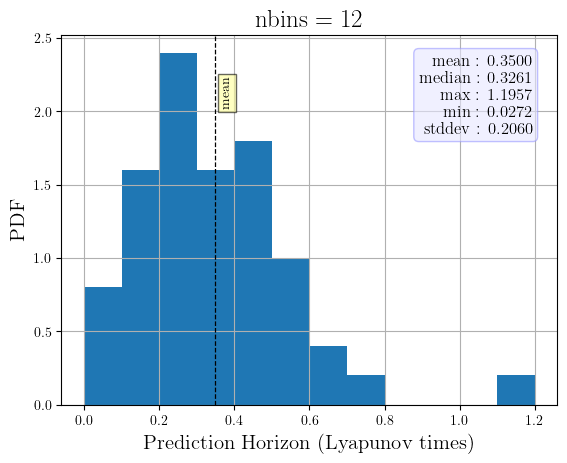

In [19]:
median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

ph_mean = np.mean(prediction_horizon_arr)
ph_max = np.max(prediction_horizon_arr)
ph_min = np.min(prediction_horizon_arr)
ph_stddev = np.std(prediction_horizon_arr)

s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print('\n'+s)

savefig_fname = '/prediction_horizons-'+data_to_consider+'data--PODGalerkin'
if savefig_fname != None:
    npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data--PODGalerkin'
    np.savez(
        dir_name_pod+npsavedata_fname,
        prediction_horizon_arr=prediction_horizon_arr,
        error_threshold=error_threshold,
    )

    with open(dir_name_pod+npsavedata_fname+'--statistics.txt', 'w') as fl:
        fl.write(s)

fig, ax = plt.subplots()

bin_width = 0.1
bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
nbins = max(1, int(np.round(bin_end/bin_width)))

bin_begin = 0.0
density = True
ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=density)
ax.axvline(prediction_horizon, linewidth=0.9, linestyle='--', color='k')

ax.set_xlabel('Prediction Horizon (Lyapunov times)', **xlabel_kwargs)
ax.set_ylabel('PDF', **ylabel_kwargs)

ax.grid(True)
# ax.set_axisbelow(True)

ax.text(
    0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
    0.8,
    'mean',
    rotation=90,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor=np.array([255,255,153])/255, alpha=0.6, boxstyle='square,pad=0.2'),
    transform=ax.transAxes
)

text_xy = [0.95, 0.95]
ax.text(
    text_xy[0],
    text_xy[1],
    'mean : {:.4f}\nmedian : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
        ph_mean,
        median,
        ph_max,
        ph_min,
        ph_stddev,
    ),
    transform=ax.transAxes,
    bbox=dict(
        boxstyle="round",
        ec=(0.6, 0.6, 1),
        fc=(0.9, 0.9, 1),
        alpha=0.6,
    ),
    # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
    horizontalalignment='right',
    verticalalignment='top',
    **legend_kwargs
)

ax.set_title('nbins = {}'.format(nbins), **title_kwargs)

if savefig_fname is not None:
    fig.savefig(
        dir_name_pod+'/plots/'+savefig_fname+'.pdf',
        dpi=300,
        bbox_inches='tight')
    plt.show()
    plt.close()
else:
    plt.show()
    print('')

d_idx : 11
0.5072491968467052


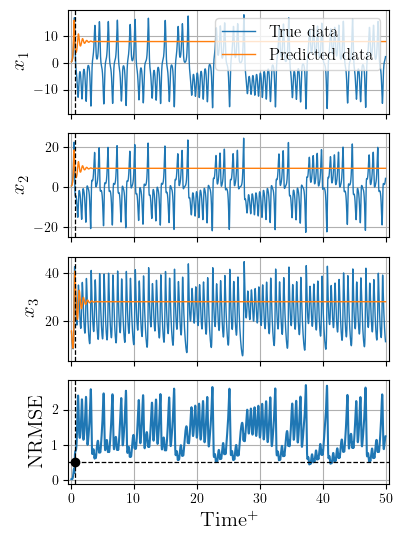

In [21]:
dir_name_AR_AErnn = dir_name_pod
# data_rnn_input = main_tuple[0][1]
# data_rnn_output = main_tuple[0][2]
normalization_constant_arr_aedata = np.array([pod_centering_means, [1]*pod_centering_means.shape[0]])
# time_stddev_ogdata = main_tuple[0][4]
# num_outsteps = main_tuple[0][5]
# lyapunov_time_arr = main_tuple[0][6]
dt_rnn = delta_t

lyap_time = np.mean(lyapunov_time_arr)
data_idx_arr = np.linspace(0, data_rnn_input.shape[0]-1, predictions_arr.shape[0], dtype=np.int32)
AR_testing_data_rnn_input = data_rnn_input[data_idx_arr]
AR_testing_data_rnn_output = data_rnn_output[data_idx_arr]

d_idx = 11# np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])

title_str = 'POD-Galerkin'

for i_mt in range(1, 2):
    prediction = predictions_arr
    # d_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
    # d_idx = 7 # 1, 7, 11, 86, 99
    print('d_idx : {}'.format(d_idx))

    num_sample_input_AR = prediction.shape[-2]
    num_sample_input_AR = AR_testing_data_rnn_input.shape[-2]

    n = 1
    num_latent_states = prediction.shape[-1]
    N = prediction.shape[-2]#num_output_timesteps

    num_cols = 1
    num_rows = n*num_latent_states+1

    ax_ylabels = [r'$x_{'+str(i+1)+'}$' for i in range(num_latent_states)]

    fig, ax = plt.subplots(
        num_latent_states+1, 1,
        sharex=True,
        figsize=np.array([7.5*num_cols, 2.5*num_rows])*0.55)
    if num_latent_states == 1:
        ax = [ax]

    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

    prev_idx = 0

    time_arr_warmup1 = (np.arange(num_sample_input_AR+1) - num_sample_input_AR)*dt_rnn
    # time_arr_warmup2 = time_arr_warmup1 + dt_rnn

    time_arr_warmup1 /= lyap_time
    # time_arr_warmup2 /= lyap_time

    input_time = time_arr_warmup1[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

    din_shape = np.array(AR_testing_data_rnn_input[d_idx].shape)
    din_shape[0] += 1
    data_in_plot = np.empty(shape=din_shape)
    data_in_plot[:-1] = AR_testing_data_rnn_input[d_idx]
    data_in_plot[-1] = AR_testing_data_rnn_output[d_idx, 0]
    data_out_plot = np.empty_like(AR_testing_data_rnn_output[d_idx])
    data_out_plot[:] = AR_testing_data_rnn_output[d_idx]

    # data_in_plot = invert_normalization(data_in_plot, normalization_constant_arr_aedata)
    # data_out_plot = invert_normalization(data_out_plot, normalization_constant_arr_aedata)


    for j in range(num_latent_states):
        for i in range(n):
            # ax[j].plot(time_arr_warmup1, data_in_plot[:, j], linestyle='--', linewidth=1, color=colors[2*i], label='__nolabel__')#'actual warmup data')#.format(i+1))
            # ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
            ax[j].plot(
                input_time,
                data_out_plot[:, j],
                linewidth=1,
                # color=colors[2*i],
                label='True data')# .format(i+1))
            ax[j].plot(
                input_time,
                prediction[d_idx, :, j],
                linewidth=1,
                # color=colors[2*i+1],
                label='Predicted data')#.format(i+1))
        ax[j].set_ylabel(ax_ylabels[j], **ylabel_kwargs)
        ax[j].grid(True)
        ax[j].set_axisbelow(True)
        # ax[j].set_ylim([-1, 1])
        ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]+0.5])


    # ax[-2].set_xlabel('Time$^+$', **xlabel_kwargs)

    max_rows = 10
    max_rows = float(max_rows)
    # ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
    ncols = int(np.ceil(1 / max_rows))
    ax[0].legend(
        loc=1,
        ncol=ncols,
        **legend_kwargs,
    )
    # ax[0].set_title(r"Lorenz $'63$ ("+title_str+")", **title_kwargs)
    # ax[0].set_title(r"Lorenz $'63$", **title_kwargs)


    ### error computation
    error = (data_out_plot - prediction[d_idx])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

    # print(norm_sq_time_average(data_out)**0.5)

    # fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
    ax2 = ax[-1]
    ax2.plot(input_time, error)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    ax2.set_xlabel('Time$^+$', **xlabel_kwargs)
    ax2.set_ylabel('NRMSE', **ylabel_kwargs)

    error_threshold = 0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if len(predhor_idx.shape) == 0 or predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]-1
    else:
        predhor_idx = np.sort(predhor_idx)[0]
    ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
    ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    # ax2.plot(input_time[predhor_idx], error_threshold, 'o', color='k')
    # ax2.axhline(error_threshold, linewidth=0.9, linestyle='--', color='k')

    for i in range(len(ax)):
        ax[i].axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    # ax2.set_ylim([0, 2])

    prediction_horizon = predhor_idx*dt_rnn/lyap_time
    print(prediction_horizon)

    plt.tight_layout()

    plot_idx = '{:04d}'.format(num_outsteps[i_mt-2]) if i_mt >= 2 else 'ZERO'
    plt.savefig(dir_name_AR_AErnn+'/plots/time_prediction--{}outsteps.pdf'.format(plot_idx), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

    np.savez(
        dir_name_AR_AErnn+'/plots/time_prediction--{}outsteps'.format(plot_idx),
        data_in_plot=data_in_plot,
        data_out_plot=data_out_plot,
        prediction=prediction[d_idx],
        error=error,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        dt_rnn=dt_rnn,
        lyapunov_time_arr=lyapunov_time_arr,
        num_outsteps=[plot_idx],
    )

In [22]:
from scipy.stats import gaussian_kde, wasserstein_distance

6.417131472553026


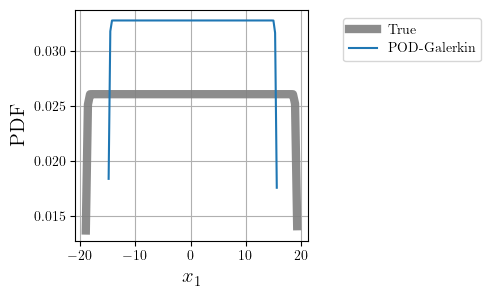

6.859420400901915


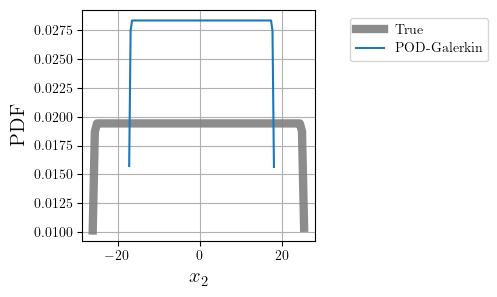

23.372578616264583


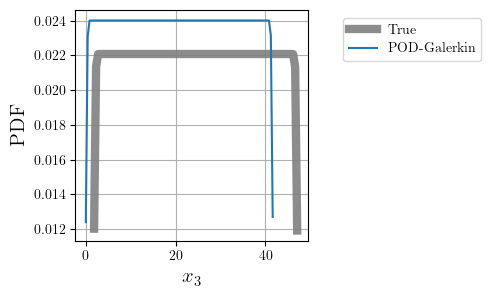

POD-Galerkin
x1 W1 : 6.4171E+00
x2 W1 : 6.8594E+00
x3 W1 : 2.3373E+01



In [23]:
width = 0.02
W1_global = []
for i in range(3):
    W1_xi = []
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    dataout_xi = np.reshape(AR_testing_data_rnn_output[:, ::10, i], (-1,))
    min_ = np.min(dataout_xi)
    max_ = np.max(dataout_xi)
    min_fac = int(min_//width)
    max_fac = -int( (-max_)//width )
    bins = np.arange(min_fac, max_fac+1)*width
    temp_ = np.histogram(dataout_xi, bins=bins, density=True)
    kernel = gaussian_kde(temp_[1], bw_method=0.02)
    
    input_plot = np.linspace(min_, max_, 101)
    p_plot = kernel(input_plot)
    ax.plot(
        input_plot,
        p_plot,
        label='True',
        linewidth=6,
        alpha=0.9,
        color='grey',
    )
    
    for i_mt in range(1):
        # prediction_tuple = main_tuple[i_mt]
        preds_xi = np.reshape(prediction[:, ::10, i], (-1,))
        min_ = np.min(preds_xi)
        max_ = np.max(preds_xi)
        min_fac = int(min_//width)
        max_fac = -int( (-max_)//width )
        bins = np.arange(min_fac, max_fac+1)*width
        plot_idx = int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)
        temp_ = np.histogram(
            preds_xi,
            bins=bins,
            density=True,
        )
        kernel = gaussian_kde(temp_[1], bw_method=0.02)

        input_plot = np.linspace(min_, max_, 101)
        p_plot = kernel(input_plot)
        ax.plot(
            input_plot,
            p_plot,
            label='POD-Galerkin'.format(plot_idx),
            # label='Predicted',
            # linewidth=0.9,
            # linestyle='--',
        )
        W1 = wasserstein_distance(dataout_xi, preds_xi)
        W1_xi.append(W1)
        print(W1)
    
    W1_global.append(W1_xi)

    ax.set_xlabel(r'$x_'+str(i+1)+r'$', **xlabel_kwargs)
    ax.set_ylabel('PDF', **ylabel_kwargs)

    plt.grid(True)
    fig.legend(bbox_to_anchor=[1.5, 0.875])
    
    plt.savefig(dir_name_AR_AErnn+'/plots/longterm--x{}_pdf.pdf'.format(i+1), dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()
    
with open(dir_name_AR_AErnn+'/plots/longterm--pdf--W1.txt', 'w') as f:
#     s = 'num_outsteps_AR : '
#     s += ', '.join(['{:2d}'.format(int(num_outsteps[i_mt-2]) if i_mt >= 2 else int(0)) for i_mt in range(1, len(main_tuple))])
    s = 'POD-Galerkin'
    s += '\n'
    for i in range(len(W1_global)):
        s += 'x{} W1 : '.format(i+1) + ', '.join(['{:.4E}'.format(elem) for elem in W1_global[i]])
        s += '\n'
    f.write(s)
    print(s)    